# Project 1: Wildlife Conservation in Cote d'Ivoire

## Part II: Binary Classification

**Objectives:**
- Resize the images to standard size and convert the images mode to RGB.
- Design and train a shallow neural network to predict an image contains 'bird' or it is blank
- Save model and model parameters.

## Getting ready

In [3]:
import os
import sys

import PIL
import torch
import matplotlib
import torchvision

import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from torchinfo import summary
from collections import Counter
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


Check version of the libraries

In [ ]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("matplotlib version:", matplotlib.__version__)
print("pandas version:", pd.__version__)
print("PIL version:", PIL.__version__)
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

Platform: win32
Python version: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
---
matplotlib version: 3.8.4
pandas version: 2.2.2
PIL version: 10.4.0
torch version: 2.5.1
torchvision version: 0.20.1


Check for available device for data and model.

In [ ]:
if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("Device:", torch.cuda.get_device_name())
    device = 'cuda'
else:
    print("CUDA is not available")
    print("Device: CPU")
    device = "cpu"

CUDA is not available
Device: CPU


### Import Data

The training data is arranged into 2 folders, one for bird images and another for no animal present images.

In [ ]:
train_dir = os.path.join('data/train_images/', 'binary_classes')
print("Train directory:", train_dir)

Train directory: data/train_images/binary_classes


In [ ]:
labels = os.listdir(train_dir)
print('Labels:', labels)

Labels: ['bird', 'blank']


In [ ]:
bird_path = os.path.join(train_dir, 'bird')
bird_images = os.listdir(bird_path)
print('Bird images:', len(bird_images))

blank_path = os.path.join(train_dir, 'blank')
blank_images = os.listdir(blank_path)
print('Blank images:', len(blank_images))

Bird images: 1641
Blank images: 2213


Bird image mode and size: RGB (960, 540)


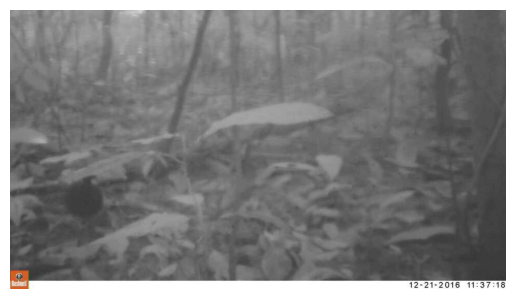

In [ ]:
bird_image = Image.open(os.path.join(bird_path, bird_images[0]))
print('Bird image mode and size:', bird_image.mode, bird_image.size)
plt.imshow(bird_image)
plt.axis('off')
plt.show()

Blank image mode and size: RGB (960, 540)


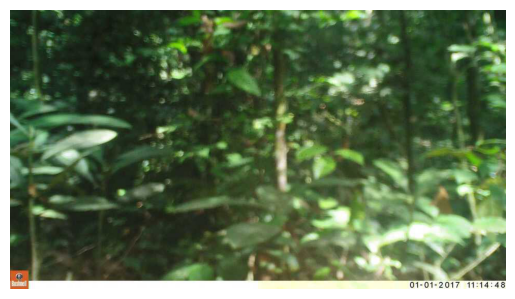

In [ ]:
blank_image = Image.open(os.path.join(blank_path, blank_images[0]))
print('Blank image mode and size:', blank_image.mode, blank_image.size)
plt.imshow(blank_image)
plt.axis('off')
plt.show()

### Preparing The Data
- convert the image to RGB format
- make the sizes same, resize the image
- convert the images to tensors

Use preprocessing pipeline to do the above tasks.

In [1]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return img            

In [5]:
transform = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]
)

print(type(transform))
print(transform)

<class 'torchvision.transforms.transforms.Compose'>
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### Load the data and transform.

In [ ]:
data = datasets.ImageFolder(root= train_dir, transform=transform)
print(data)

Dataset ImageFolder
    Number of datapoints: 3854
    Root location: data/train_images/binary_classes
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [ ]:
data.class_to_idx

{'bird': 0, 'blank': 1}

Hence, there are two classes with 0 for 'bird', and 1 for 'blank'. This is based on the data arrangement in the training images folder.

In [ ]:
data.imgs[:5]

[('data/train_images/binary_classes\\bird\\ZJ000000.jpg', 0),
 ('data/train_images/binary_classes\\bird\\ZJ000002.jpg', 0),
 ('data/train_images/binary_classes\\bird\\ZJ000009.jpg', 0),
 ('data/train_images/binary_classes\\bird\\ZJ000017.jpg', 0),
 ('data/train_images/binary_classes\\bird\\ZJ000060.jpg', 0)]

In [ ]:
# List of class values
set(data.targets)

{0, 1}

Split the data into `train` and `validation` sets.

In [ ]:
g = torch.Generator()
g.manual_seed(42)

train_data, val_data = random_split(data, [0.8, 0.2], generator=g)

In [ ]:
print('Length of training set:', len(train_data))
print('Length of validation set:', len(val_data))

Length of training set: 3084
Length of validation set: 770


In [ ]:
def class_counts(data):
    c = Counter(x[1] for x in tqdm(data, desc= 'Counting classes'))
    class_index = data.dataset.class_to_idx
    return pd.Series({cat: c[i] for cat, i in class_index.items()})

In [ ]:
train_counts = class_counts(train_data)
train_counts

Counting classes: 100%|██████████| 3084/3084 [00:18<00:00, 165.39it/s]


bird     1326
blank    1758
dtype: int64

<Axes: >

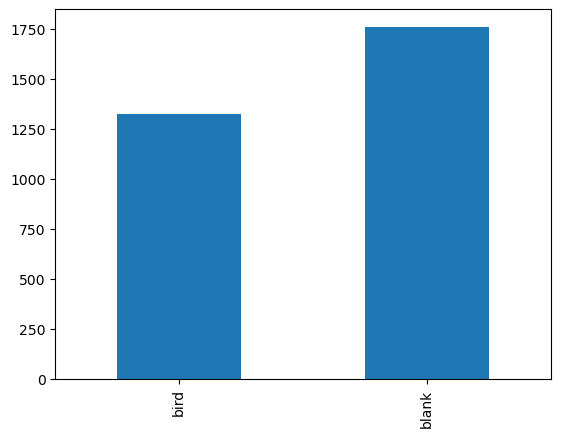

In [ ]:
train_counts.sort_values().plot(kind= 'bar')

Counting classes: 100%|██████████| 770/770 [00:05<00:00, 140.99it/s]


<Axes: >

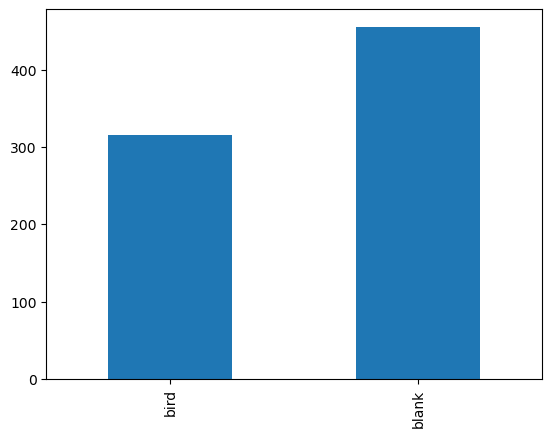

In [ ]:
val_counts = class_counts(val_data)
val_counts
val_counts.sort_values().plot(kind= 'bar')

In [ ]:
val_counts

bird     315
blank    455
dtype: int64

In [ ]:
print('Training data classes:', train_data.dataset.class_to_idx)
print('Validation data classes:', val_data.dataset.class_to_idx)

Training data classes: {'bird': 0, 'blank': 1}
Validation data classes: {'bird': 0, 'blank': 1}


Both the training and validation sets are similarly distributed.

Now, create a `DataLoader` objects, iterables used to train and batch size of 32 is used. For the training, shuffling is on that will be used to randomly rearrange the data after we have gone over all of the batches. This prevents any particular batch of the data from having too much influence on the training.

In [ ]:
g = torch.Generator()
g.manual_seed(42)

train_loader = DataLoader(train_data, batch_size= 32, shuffle= True, generator= g)

val_loader = DataLoader(val_data, batch_size= 32, shuffle= False, generator= g)

print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


Let's see one batch of images and labels. One batch of images should be 4D tensor with dimension [32, 3, 224, 224] for which there are 32 images in one batch, 3 channels for each image (RGB), and the images have height and width of 224.

One batch of labels should be a 1D tensor of length 32.

In [ ]:
fir_data = iter(train_loader)
imgs, labels = next(fir_data)

print('Shape of the first batch of the images:', imgs.shape)
print('Shape of the first batch of the labels:', labels.shape)

Shape of the first batch of the images: torch.Size([32, 3, 224, 224])
Shape of the first batch of the labels: torch.Size([32])


### Building a shallow neural network
The network will have 4 layers of 1 input layer, 2 hidden layers and 1 output layer.

The input data are tensors of the images with dimension of *3x224x224*. The neural network only accept input in one dimension. So the `imgs` should be flatten to get a dimension having shape of `[32, 150528]`. The 150528 is the product 3x224x224.

In [ ]:
flatten = nn.Flatten()
tensor_flatten = flatten(imgs)

print('Shape of the flattened tensor:', tensor_flatten.shape)

Shape of the flattened tensor: torch.Size([32, 150528])


THe following code defines the architecture of the network with the sequence of layers.

In [ ]:
height, width = 224, 224

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * height * width, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
)

print('Model type:', type(model))
print('Model Structure:')
model

Model type: <class 'torch.nn.modules.container.Sequential'>
Model Structure:


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
)

In [ ]:
# The output layer
model.append(nn.Linear(128, 2))
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
summary(model, input_size= (32, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 2]                   --
├─Flatten: 1-1                           [32, 150528]              --
├─Linear: 1-2                            [32, 512]                 77,070,848
├─ReLU: 1-3                              [32, 512]                 --
├─Linear: 1-4                            [32, 128]                 65,664
├─ReLU: 1-5                              [32, 128]                 --
├─Linear: 1-6                            [32, 2]                   258
Total params: 77,136,770
Trainable params: 77,136,770
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 2.47
Input size (MB): 19.27
Forward/backward pass size (MB): 0.16
Params size (MB): 308.55
Estimated Total Size (MB): 327.98

### Training the Model

We need:
- loss function to measure how well the model performs on a given data
- optimizer that is used to adjust the model parameters to minimize the loss function

In [ ]:
loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

The following function will be used for training process. It accepts:
- ***model***: PyTorch model with specific parameters
- ***optimizer***: used to best adjust the model weights
- ***loss_func***: loss function that the optimizer tries to minimize
- ***data_loader***: DataLoader object for training dataset to iterate over the batches

The function returns the average loss function on the training data over the entire epoch.

In [ ]:
def train_epoch(model, optimizer, loss_func, data_loader):
    # instantiate the loss value for each epoch
    train_loss = 0.0

    # set the model to training mode
    model.train()

    # iterate over the entire baches of training data for one epoch
    for inp, targ in tqdm(data_loader, desc= 'Training', leave= False):
        # set the gradients to zero
        optimizer.zero_grad()

        # forward pass the inputs to the model and obtain the logits,
        # then the logits (out) are used to  calculate loss
        out = model(inp)
        loss = loss_func(out, targ)

        # calculate the numerical value of the derivative of the loss
        # function with respect to all the trainable model weights. This
        # gives gradients. Then optimizer take a 'step', meaning updates
        # or adjust the model weights.
        loss.backward()
        optimizer.step()

        # increment the training loss for the current batch
        train_loss += loss.data.item() * inp.size(0)

    # return the average training loss
    return train_loss / len(data_loader.dataset)

In [ ]:
loss_val = train_epoch(model, optimizer, loss_func, train_loader)
print(f'The average loss during the training epoch was {loss_val:.2f}.')

The average loss during the training epoch was 1.89.


In [ ]:
# One additional training
loss_val = train_epoch(model, optimizer, loss_func, train_loader)
print(f'The average loss during the training epoch was {loss_val:.2f}.')

The average loss during the training epoch was 1.02.


The following function will make predictions for each of the data in ***data_loader*** using ***model***.

In [ ]:
def predict(model, data_loader):
    # define a tensor that stores all of the predictions
    all_probs = torch.tensor([])

    # set the model to evaluation mode
    model.eval()

    # here, no need to calculate any gradient
    with torch.no_grad():
        # iterate over the batches in the data loader
        for inp, targ in tqdm(data_loader, desc= 'Prediction', leave= False):
            # the model produces logits
            out = model(inp)

            # convert these logits into probabilities
            probs = torch.nn.functional.softmax(out, dim= 1)
            all_probs = torch.cat((all_probs, probs), dim= 0)
        
    return all_probs

In [ ]:
train_probs = predict(model, train_loader)
print(train_probs[:5])

tensor([[0.7907, 0.2093],
        [0.9035, 0.0965],
        [0.9146, 0.0854],
        [0.8741, 0.1259],
        [0.9016, 0.0984]])


In [ ]:
print(train_probs.shape)

torch.Size([3084, 2])


The `predict` function returns two numbers for each input. The first is the probability that the image is of the first class ('bird') and the second is the probability that it's of the second class ('blank'). These numbers add up to one.

In [ ]:
print(train_probs[0].sum())

tensor(1.)


In [ ]:
val_probs = predict(model, val_loader)
print('The first five predicitions on the validation data:')
print(val_probs[:5])
print('Sum of the probabilities:', val_probs[0].sum())

The first five predicitions on the validation data:
tensor([[0.4862, 0.5138],
        [0.8354, 0.1646],
        [0.3332, 0.6668],
        [0.9052, 0.0948],
        [0.5545, 0.4455]])
Sum of the probabilities: tensor(1.0000)


To make predictions from these probabilities, we predict class with the highest probabilty for each row.

In [ ]:
train_preds = torch.argmax(train_probs, dim= 1)
print('Prediction shape:', train_preds.shape)
print('The first 10 predictions on the training data:')
print(train_preds[:10])

Prediction shape: torch.Size([3084])
The first 10 predictions on the training data:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
val_preds = torch.argmax(val_probs, dim= 1)
print(f'Prediction shape on the validation: {val_preds.shape}.')
print('The first 10 predictions on the validation data:')
print(val_preds[:10])

Prediction shape on the validation: torch.Size([770]).
The first 10 predictions on the validation data:
tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 0])


Compare the training set predictions to that of the actual labels for the training set.

In [ ]:
train_targ = torch.cat([labels for _, labels in train_loader])
train_is_correct = torch.eq(train_preds, train_targ)
train_total_correct = torch.sum(train_is_correct).item()
train_acc = train_total_correct / len(train_loader.dataset)

print(f'Accuracy on the training data: {train_acc:.3f}.')

Accuracy on the training data: 0.462.


In [ ]:
val_targ = torch.cat([labels for _, labels in val_loader])
val_is_correct = torch.eq(val_preds, val_targ)
val_total_correct = torch.sum(val_is_correct).item()
val_acc = val_total_correct / len(val_loader.dataset)

print(f'Accuracy on the validation data: {val_acc:.3f}.')

Accuracy on the validation data: 0.577.


The next function calculates both the loss and accuracy batch by batch.

In [ ]:
def score(model, data_loader, loss_func):
    # initialize total loss and correct predictions.
    total_loss = 0
    total_cor_pred = 0

    # set the model to evaliation mode.
    model.eval()

    with torch.no_grad():
        # iterate over each batch and feed them into the model
        for inp, targ in tqdm(data_loader, desc= 'Scoring', leave= False):
            out = model(inp)

            # calculate loss and correct predicions
            loss = loss_func(out, targ)
            total_loss += loss.data.item() * inp.size(0)

            correct = torch.eq(torch.argmax(out, dim= 1), targ)
            total_cor_pred += torch.sum(correct).item()

    return total_loss / len(data_loader.dataset), total_cor_pred / len(data_loader.dataset)

In [ ]:
train_loss, train_acc = score(model, train_loader, loss_func)
print(f'Model average loss value on the training data: {train_loss:.3f}.')
print(f'Model accuracy on the training data: {train_acc:.3f}.')

Model average loss value on the training data: 0.718.
Model accuracy on the training data: 0.611.


In [ ]:
val_loss, val_acc = score(model, val_loader, loss_func)
print(f'Model average loss value on the validation data: {val_loss:.3f}.')
print(f'Model accuracy on the validation data: {val_acc:.3f}.')

Model average loss value on the validation data: 0.482.
Model accuracy on the validation data: 0.769.


Finally, the following function will run over a number of epochs, calling `train_epoch` and `score` functions, and printing important information.

In [ ]:
def train(model, optimizer, loss_func, train, val, epochs= 20):
    for epoch in range(1, epochs + 1):
        train_loss = train_epoch(model, optimizer, loss_func, train)

        val_loss, val_acc = score(model, val, loss_func)

        print(f'Epoch: {epoch}, Training loss: {train_loss:.3f},')
        print(f'Validation loss: {val_loss:.3f}, Validation accuracy: {val_acc:.3f}')

In [ ]:
train(model, optimizer, loss_func, train_loader, val_loader, epochs= 5)

Epoch: 1, Training loss: 0.675,
Validation loss: 0.608, Validation accuracy: 0.712


Epoch: 2, Training loss: 0.543,
Validation loss: 0.492, Validation accuracy: 0.749


Epoch: 3, Training loss: 0.501,
Validation loss: 0.460, Validation accuracy: 0.803


Epoch: 4, Training loss: 0.508,
Validation loss: 0.465, Validation accuracy: 0.768


Epoch: 5, Training loss: 0.532,
Validation loss: 0.482, Validation accuracy: 0.769


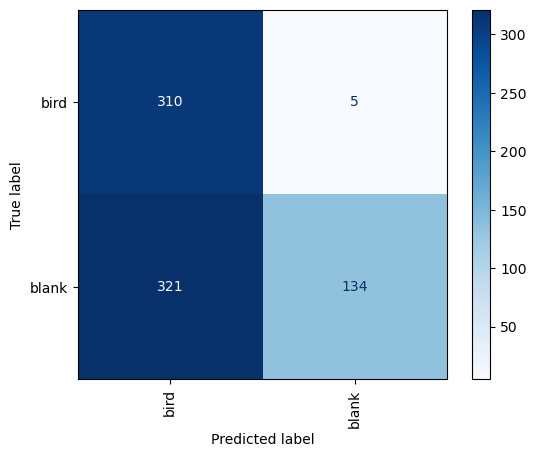

In [ ]:
conf_mat = confusion_matrix(val_targ, val_preds)
disp = ConfusionMatrixDisplay(
    confusion_matrix= conf_mat,
    display_labels= ['bird', 'blank']
)
disp.plot(cmap= plt.cm.Blues, xticks_rotation= 'vertical')

Test the model on one chosen image from `bird` folder.

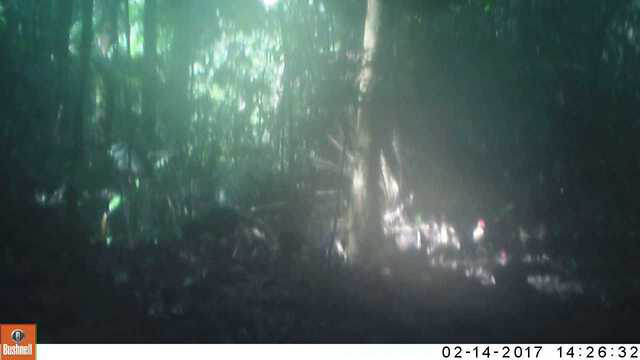

In [ ]:
test_img = 'data/train_images/binary_classes/bird/ZJ002024.jpg'
Image.open(test_img)

In [ ]:
labels= ['bird', 'blank']

img = Image.open(test_img)
img = transform(img)
img = torch.unsqueeze(img, 0)

model.eval()
pred = torch.nn.functional.softmax(model(img), dim= 1)
print(pred)
pred = pred.argmax()
print(labels[pred])

tensor([[0.7029, 0.2971]], grad_fn=<SoftmaxBackward0>)
bird


### Saving Models

It is possible to save the entire model using `save` which avoids having to retrain the model the next time we want to use it, or the parameters using `save_dict` which is preferable allowing to reuse parameters even if the model's structure changes or to apply parameters to another model.

In [ ]:
torch.save(model, os.path.join('model', 'shallownet'))
torch.save(model.state_dict(), os.path.join('model', 'shallownet_params'))

In this notebook, the key points are:
- The data often needs to be preprocessed. In our case, resize and convert the mode of the images has been done using ***transform.compose***.
- The fully connected model is made up of layers whose nodes are fully connected to the next layer.
- Simple (shallow) model is build using ***nn.Sequential*** by defining the order of the layers.
- Training was made by iterating through the training set. One pass through the data is called ***epoch***. An optimizer uses loss function to improve model's weights.